### Introduction

### Synthetic Protein-Protein Interaction Dataset for Multi-Instance Learning (MIL) with Key Instance Detection (KID)

Understanding protein-protein interactions (PPIs) is a central problem in biology, as these interactions drive most cellular processes. Experimentally characterizing all PPIs is costly and time-consuming, so **computational approaches** are increasingly used to predict and analyze interactions.

### Why Synthetic Data?

- Real PPI datasets can be limited, noisy, or biased.  
- Synthetic datasets allow **controlled experiments**, where we know exactly which subsequences (motifs) are responsible for interactions.  
- They are particularly useful for developing and benchmarking machine learning models.

### Multi-Instance Learning (MIL)

- In MIL, each data point is a **bag** containing multiple **instances**.  
- A **bag is labeled positive** if it contains at least one "key instance" that triggers the label; otherwise, it is negative.  
- Applied to PPIs:  
  - Each bag = a pair of proteins.  
  - Each instance = a pair of subsequences from the two proteins.  
  - Positive bags contain subsequence pairs with specific **motifs** responsible for the interaction.  

### Key Instance Detection (KID)

- KID focuses on identifying **which instances in a positive bag are truly responsible** for the label.  
- In PPI context: find the subsequence pairs (motifs) that drive the interaction.  
- **KID accuracy** measures how well a model can detect these key instances, beyond just predicting the bag label.

### Why This Setup is Useful

- Enables **benchmarking MIL models** in a controlled setting.  
- Provides **ground-truth key instances**, allowing detailed evaluation of model interpretability.  
- Supports **feature engineering** (e.g., one-hot encoding of subsequences) and flexible model design.  

With this setup, you can experiment with MIL algorithms, visualize motif contributions, and evaluate models both on bag-level predictions and key instance detection.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bag_predictions(bag, predictions, top_k=10):
    """
    Visualize a single MIL bag with predicted instance weights.
    
    Parameters:
    - bag: dict with keys:
        'protein_1' (str), 'protein_2' (str),
        'subseqs_1' (list of str), 'subseqs_2' (list of str),
        'key_indices' (list of int),
        'label' (int),
        'motifs' (tuple of str) or None
    - predictions: 1D np.array or list of predicted weights, same length as number of instances in bag.
    - top_k: int, number of top subsequence pairs to display
    
    Displays:
    - Proteins with highlighted motif occurrences (in blue).
    - Table of top_k pairs sorted by predicted weight, indicating true key instances.
    """
    
    p1 = bag['protein_1']
    p2 = bag['protein_2']
    subseqs_1 = bag['subseqs_1']
    subseqs_2 = bag['subseqs_2']
    key_indices = set(bag['key_indices'])
    label = bag['label']
    motifs = bag.get('motifs', None)  # now a tuple or None
    
    motif1, motif2 = (motifs if motifs is not None else (None, None))
    
    # Lengths
    n_subseqs_1 = len(subseqs_1)
    n_subseqs_2 = len(subseqs_2)
    
    # Find motif occurrences (positions) in each protein
    def find_motif_positions(protein, motif):
        positions = []
        if motif:
            start = 0
            while True:
                idx = protein.find(motif, start)
                if idx == -1:
                    break
                positions.extend(range(idx, idx + len(motif)))
                start = idx + 1
        return set(positions)
    
    motif_positions_1 = find_motif_positions(p1, motif1)
    motif_positions_2 = find_motif_positions(p2, motif2)
    
    # Visualize proteins with highlights for motif positions
    def highlight_protein(seq, motif_pos_set):
        """Return a list of tuples (char, highlight_bool)"""
        highlight_mask = [i in motif_pos_set for i in range(len(seq))]
        return [(c, h) for c, h in zip(seq, highlight_mask)]
    
    h_protein_1 = highlight_protein(p1, motif_positions_1)
    h_protein_2 = highlight_protein(p2, motif_positions_2)
    
    fig, axs = plt.subplots(3, 1, figsize=(14, 8))
    fig.suptitle(f"Bag label: {label} - Key instances: {len(key_indices)}", fontsize=16)
    
    def plot_highlighted_sequence(ax, highlighted_seq, title):
        ax.set_title(title)
        ax.axis('off')
        for i, (char, highlight) in enumerate(highlighted_seq):
            color = 'blue' if highlight else 'black'
            bbox = dict(facecolor='lightblue', alpha=0.5) if highlight else None
            ax.text(i, 0, char, color=color, fontsize=14, fontweight='bold' if highlight else 'normal', bbox=bbox)
        ax.set_xlim(-1, len(highlighted_seq))
        ax.set_ylim(-1, 1)
    
    plot_highlighted_sequence(axs[0], h_protein_1, f"Protein 1 (motif: {motif1 if motif1 else 'None'})")
    plot_highlighted_sequence(axs[1], h_protein_2, f"Protein 2 (motif: {motif2 if motif2 else 'None'})")
    
    # Sort predicted weights descending and get top_k pairs
    pred = np.array(predictions)
    top_indices = np.argsort(pred)[::-1][:top_k]
    
    # Prepare pairs info for display
    rows = []
    for rank, idx in enumerate(top_indices, 1):
        i = idx // n_subseqs_2
        j = idx % n_subseqs_2
        s1 = subseqs_1[i]
        s2 = subseqs_2[j]
        weight = pred[idx]
        is_key = "YES" if idx in key_indices else "NO"
        rows.append((rank, i, s1, j, s2, f"{weight:.4f}", is_key))
    
    # Display table below sequences
    col_labels = ["Rank", "Subseq idx P1", "Subseq P1", "Subseq idx P2", "Subseq P2", "Predicted weight", "Is Key Instance"]
    table_data = [[str(x) for x in row] for row in rows]
    
    axs[2].axis('off')
    table = axs[2].table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [2]:
import logging
import warnings
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)

import time
import torch
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Preprocessing
from milearn.preprocessing import BagMinMaxScaler

# Network hparams
from milearn.network.module.hopt import DEFAULT_PARAM_GRID

# MIL wrappers
from milearn.network.regressor import BagWrapperMLPNetworkRegressor, InstanceWrapperMLPNetworkRegressor
from milearn.network.classifier import BagWrapperMLPNetworkClassifier, InstanceWrapperMLPNetworkClassifier

# MIL networks
from milearn.network.classifier import (InstanceNetworkClassifier,
                                        BagNetworkClassifier,
                                        AdditiveAttentionNetworkClassifier,
                                        SelfAttentionNetworkClassifier,
                                        HopfieldAttentionNetworkClassifier,
                                        DynamicPoolingNetworkClassifier)

# Utils
from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

# Data
from seqmil.data import create_ppi_dataset
from seqmil.featurizer import OneHotFeaturizer

### 1. Create synthetic PPI dataset

This dataset simulates protein-protein interactions for **multi-instance learning (MIL)**, where each *bag* represents a protein pair with multiple subsequence pairs (instances). Some instances are **key instances** containing specific motifs that define positive interactions.

### Dataset Overview

Each **bag** corresponds to a pair of proteins (`protein_1` and `protein_2`).  

- **Positive bags**: Contain specific motif pairs, i.e., `motif1` in `protein_1` and `motif2` in `protein_2`.  
- **Negative bags**: Do **not** contain any of the specified motifs.  

Each protein is split into overlapping subsequences using a sliding window. The **bag instances** are all possible pairs of subsequences between the two proteins.

### Step-by-Step Dataset Creation

**Parameter Setup**
   - `n_bags`: Number of bags to generate  
   - `pos_ratio`: Fraction of positive bags  
   - `protein_length`: Length of synthetic protein sequences  
   - `window_size` & `step_size`: Sliding window parameters for subsequences  
   - `motif_pairs`: List of motif tuples used to generate positive bags

**Protein Sequence Generation.**
   - Each protein is randomly generated from 20 standard amino acids (`ACDEFGHIKLMNPQRSTVWY`).  

**Motif Embedding (for positive bags)**
   - A motif pair `(motif1, motif2)` is randomly selected  
   - `motif1` is embedded in `protein_1` and `motif2` in `protein_2` at random positions  

**Sliding Window Extraction**
   - Each protein is split into overlapping subsequences of length `window_size`, moving by `step_size`  
   - Example: For a protein of length 50, `window_size=10`, `step_size=3`, we get subsequences like `protein[0:10]`, `protein[3:13]`, `protein[6:16]`, etc.  

**Bag Construction**
   - Every subsequence of `protein_1` is paired with every subsequence of `protein_2`  
   - These pairs form the **instances** of the bag  
   - **Key instances** are those where both motifs are present in the corresponding subsequences  

**Negative Bag Filtering**
   - Negative bags are generated by random proteins that **do not contain any motifs** from `motif_pairs`  

**Featurization (optional)**
   - Subsequence pairs are converted to vectors using a featurizer, e.g., `OneHotFeaturizer`  
   - Each subsequence is one-hot encoded and concatenated to represent the instance vector  

In [3]:
motif_pairs = [
    # ("ALRMNDU", "APRQKVN"), 
    ("KLMNPQR", "STVWYAC")]

dataset = create_ppi_dataset(
    motif_pairs=motif_pairs,
    n_bags=1000,
    pos_ratio=0.5,
    protein_length=50,
    window_size=10,
    step_size=3,
    seed=42)

### 2. Encode protein sequences 

After generating the raw dataset, each subsequence pair in a bag needs to be converted into a numerical vector for machine learning.  

**Process:**

**One-Hot Encoding**  
   - Each amino acid in a subsequence is represented as a one-hot vector of length 20 (one for each standard amino acid).  
   - Example: `'A'` → `[1,0,0,...,0]`, `'C'` → `[0,1,0,...,0]`.  

**Subsequence Pair Encoding**  
   - For each instance `(s1, s2)` in a bag, both subsequences are one-hot encoded separately.  
   - The vectors are then concatenated to form a single vector representing the pair.  

**Bag Representation**  
   - All concatenated instance vectors in a bag are stacked into a NumPy array: `encoded_bag`.  
   - This array can then be used as input for MIL models, while `key_indices` indicate the key instances in positive bags.  

In [4]:
featurizer = OneHotFeaturizer()

for bag in dataset:
    encoded_bag = []
    for s1, s2 in bag["raw_bag"]:
        v1, v2 = featurizer.run([s1, s2])
        pair_vec = np.concatenate([v1, v2])
        encoded_bag.append(pair_vec)
    bag["encoded_bag"] = np.stack(encoded_bag)

In [5]:
dataset[0]['encoded_bag'].shape

(196, 400)

In [6]:
dataset[0]['motifs']

('KLMNPQR', 'STVWYAC')

In [7]:
dataset[1]['protein_1']

'SHGEARRYSMDPTMEIEYWWNLDIYTFFNCKLMNPQREMPYWSQRIQIVL'

In [8]:
dataset[1]['protein_2']

'FCANNARCCAHMGSTVWYACKCQIKVCQPCRTDEMDELVCTVCQMACSFK'

In [9]:
dataset[1]["key_indices"]

[130, 144]

### Key Instance Detection (KID) Accuracy

In multi-instance learning, some instances in a bag are more important—they are the **key instances** that determine whether the bag is positive.  

The KID accuracy measures **how well a model can identify these key instances** in positive bags.  

- A bag is counted as correct if the model’s top predictions include at least one of the true key instances.  
- The final KID accuracy is the fraction of positive bags where the key instance was successfully detected.  

This metric focuses on whether the model can find the most important parts of a bag, rather than just predicting the bag’s overall label.

In [10]:
# ==== KID Accuracy Function ====
def kid_accuracy(true_key_indices, predictions, labels, top_k=1):
    assert len(predictions) == len(true_key_indices) == len(labels)

    correct = 0
    total = 0

    for pred, true_keys, label in zip(predictions, true_key_indices, labels):
        if label != 1:
            continue
        total += 1

        if len(true_keys) == 0:
            continue

        top_pred_indices = np.argsort(pred)[-top_k:][::-1]  # ensure descending order
        if any(idx in true_keys for idx in top_pred_indices):
            correct += 1

    return correct / total if total > 0 else 0.0

### 3. Build model

In [11]:
# Extract encoded bags, labels, key indices, and raw sequences
raw_bags = [bag["raw_bag"] for bag in dataset]
encoded_bags = [bag["encoded_bag"] for bag in dataset]
labels = [bag["label"] for bag in dataset]
key_indices = [bag["key_indices"] for bag in dataset]



# Train/test split
x_train, x_test, y_train, y_test, key_train, key_test, seq_train, seq_test = train_test_split(
    encoded_bags, labels, key_indices, dataset,
    test_size=0.2, random_state=42, stratify=labels
)

# Scaling (using BagMinMaxScaler or any bag-level scaler)
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [12]:
model = DynamicPoolingNetworkClassifier()
model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=True)
model.fit(x_train_scaled, y_train)

Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/28 |  3.6% |  5.3 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 31, Loss: 0.0106
[2/28 |  7.1% |  0.6 min] Value: (256, 128, 64), Epochs: 25, Loss: 0.0265
[3/28 | 10.7% |  5.9 min] Value: (128,), Epochs: 572, Loss: 0.0173
Best hidden_layer_sizes = (2048, 1024, 512, 256, 128, 64), val_loss = 0.0106
Optimizing hyperparameter: activation (5 options)
[4/28 | 14.3% |  8.7 min] Value: relu, Epochs: 23, Loss: 0.0099
[5/28 | 17.9% |  8.7 min] Value: leakyrelu, Epochs: 25, Loss: 0.0092
[6/28 | 21.4% | 10.1 min] Value: gelu, Epochs: 30, Loss: 0.0101
[7/28 | 25.0% |  9.7 min] Value: elu, Epochs: 26, Loss: 0.0200
[8/28 | 28.6% |  8.1 min] Value: silu, Epochs: 21, Loss: 0.0065
Best activation = silu, val_loss = 0.0065
Optimizing hyperparameter: learning_rate (2 options)
[9/28 | 32.1% |  4.7 min] Value: 0.0001, Epochs: 25, Loss: 0.0237
[10/28 | 35.7% |  5.2 min] Value: 0.001, Epochs: 29, Loss: 0.0174
Best learning_rate = 0.001, val_

DynamicPoolingNetworkClassifier(
  (instance_transformer): Sequential(
    (0): Linear(in_features=400, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): SiLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): SiLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SiLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): SiLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): SiLU()
  )
  (bag_estimator): Norm()
  (dynamic_pooling): DynamicPooling()
)

In [13]:
y_prob = model.predict(x_test_scaled)
y_pred = np.where(y_prob > 0.5, 1, 0)

w_pred = model.get_instance_weights(x_test_scaled)
w_pred = [w.flatten() for w in w_pred]

In [14]:
print(f"Classification accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"KID accuracy: {kid_accuracy(key_test, w_pred, y_test, top_k=1):.2f}")

Classification accuracy: 0.99
KID accuracy: 0.99


In [15]:
# bags with correct positive class prediction (use these indexes for visualization)
np.where((y_pred == 1) & (np.array(y_test) == 1))[0]

array([  0,   2,   4,   5,   6,  12,  13,  14,  15,  20,  21,  23,  24,
        25,  27,  28,  29,  30,  35,  38,  39,  40,  43,  44,  47,  52,
        55,  59,  62,  65,  66,  67,  71,  72,  76,  77,  78,  79,  80,
        83,  86,  87,  88,  89,  90,  96,  97,  98, 101, 102, 106, 109,
       110, 111, 112, 114, 116, 117, 118, 120, 123, 124, 128, 133, 144,
       145, 148, 149, 152, 153, 157, 158, 159, 161, 162, 165, 166, 167,
       169, 170, 171, 177, 179, 180, 184, 185, 189, 190, 191, 192, 193,
       194, 196, 197, 198])

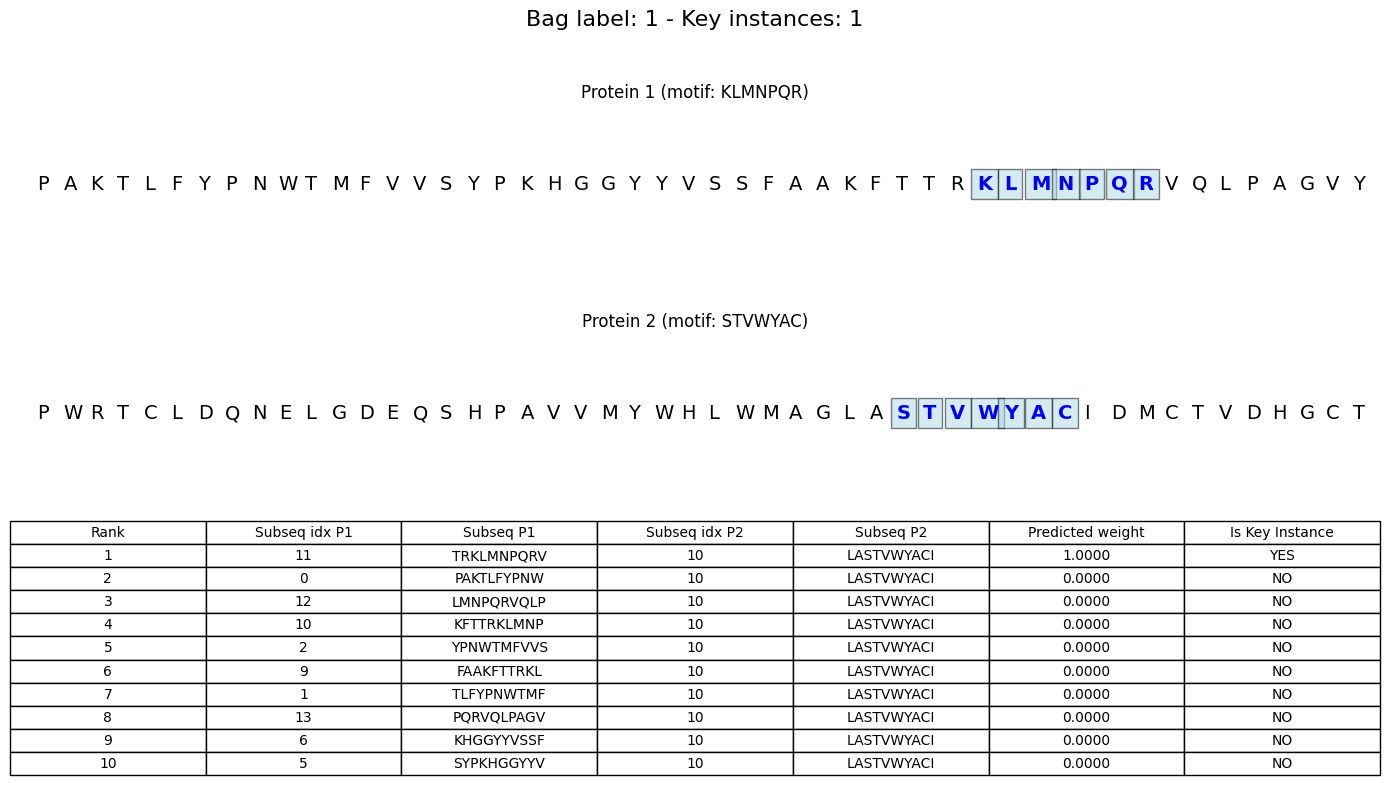

In [16]:
N = 2
visualize_bag_predictions(seq_test[N], w_pred[N], top_k=10)

### 4. Mini-benchmark

In [17]:
classifier_list = [
    
        # attention mil networks
        ("AdditiveAttentionNetworkClassifier", AdditiveAttentionNetworkClassifier()),
        ("SelfAttentionNetworkClassifier", SelfAttentionNetworkClassifier()),
        ("HopfieldAttentionNetworkClassifier", HopfieldAttentionNetworkClassifier()),

        # other mil networks
        ("DynamicPoolingNetworkClassifier", DynamicPoolingNetworkClassifier()),
    ]

In [18]:
res_df = pd.DataFrame()
for model_idx, (name, model) in enumerate(classifier_list, 1):
    print(f"  [Model {model_idx}/{len(classifier_list)}] Training model: '{name}'")

    # train model
    model.hopt(x_train_scaled, y_train, param_grid=DEFAULT_PARAM_GRID, verbose=True)
    model.fit(x_train_scaled, y_train)
    
    # predict
    y_pred = model.predict(x_test_scaled)
    y_pred = np.where(y_prob > 0.5, 1, 0)
    w_pred = model.get_instance_weights(x_test_scaled)
    w_pred = [w.flatten() for w in w_pred]
    #
    res_df.loc[name, "PRED_ACC"] = accuracy_score(y_test, y_pred)
    res_df.loc[name, "KID_RANK"] = kid_accuracy(key_test, w_pred, y_test, top_k=1)

print("\nAll models completed.")

  [Model 1/4] Training model: 'AdditiveAttentionNetworkClassifier'
Optimizing hyperparameter: hidden_layer_sizes (3 options)
[1/31 |  3.2% |  2.7 min] Value: (2048, 1024, 512, 256, 128, 64), Epochs: 18, Loss: 0.1943
[2/31 |  6.5% |  0.6 min] Value: (256, 128, 64), Epochs: 24, Loss: 0.0517
[3/31 |  9.7% |  0.5 min] Value: (128,), Epochs: 26, Loss: 0.0910
Best hidden_layer_sizes = (256, 128, 64), val_loss = 0.0517
Optimizing hyperparameter: activation (5 options)
[4/31 | 12.9% |  0.4 min] Value: relu, Epochs: 18, Loss: 0.0589
[5/31 | 16.1% |  0.5 min] Value: leakyrelu, Epochs: 18, Loss: 0.0973
[6/31 | 19.4% |  0.4 min] Value: gelu, Epochs: 19, Loss: 0.0692
[7/31 | 22.6% |  0.4 min] Value: elu, Epochs: 18, Loss: 0.0998
[8/31 | 25.8% |  0.5 min] Value: silu, Epochs: 21, Loss: 0.0447
Best activation = silu, val_loss = 0.0447
Optimizing hyperparameter: learning_rate (2 options)
[9/31 | 29.0% |  0.6 min] Value: 0.0001, Epochs: 64, Loss: 0.0474
[10/31 | 32.3% |  0.2 min] Value: 0.001, Epochs: 

In [19]:
res_df.round(2)

,PRED_ACC,KID_RANK
AdditiveAttentionNetworkClassifier,1.0,1.00
SelfAttentionNetworkClassifier,1.0,0.96
HopfieldAttentionNetworkClassifier,1.0,0.69
DynamicPoolingNetworkClassifier,1.0,1.00
